# Finger Printing Inequality for Multiple Access Channels

This notebook explores the performance against a finger printing task where the receiver must output $0$ when inputs $x=y$ and $1$ otherwise.
The notebook demonstrates that quantum communication provides no advantage in this task, however, entanglement shared between the senders yields an advantage when classical communication is used.

In [2]:
from qnet_context import QNetOptimizer as QNopt
from mac_context import *
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt

In [7]:
arb_prep_nodes = [
    QNopt.PrepareNode(3, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.PrepareNode(3, [1], qml.templates.subroutines.ArbitraryUnitary, 3),
]
arb_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

arb_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, arb_meas_nodes)

real_prep_nodes = [
    QNopt.PrepareNode(3, [0], QNopt.local_RY, 1),
    QNopt.PrepareNode(3, [1], QNopt.local_RY, 1),
]

def CNOT_RY(settings, wires):
    qml.CNOT(wires=wires)
    QNopt.local_RY(settings, wires)

real_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], CNOT_RY, 2)
]


real_ansatz = QNopt.NetworkAnsatz(real_prep_nodes, real_meas_nodes)


def local_arb_rot(settings, wires):
    qml.templates.subroutines.ArbitraryUnitary(settings[0:3], wires=[wires[0]])
    qml.templates.subroutines.ArbitraryUnitary(settings[3:6], wires=[wires[1]])

local_meas_nodes = [
    QNopt.MeasureNode(1, 2, [0,1], local_arb_rot, 6),
]

local_ansatz = QNopt.NetworkAnsatz(arb_prep_nodes, local_meas_nodes)

ea_prep_nodes = [
    QNopt.PrepareNode(1, [0,1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

# hack on number of outputs
ea_meas_nodes = [
    QNopt.MeasureNode(3, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(3, 1, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

ea_ansatz = QNopt.NetworkAnsatz(ea_prep_nodes, ea_meas_nodes)

bell_ea_prep_nodes = [
    QNopt.PrepareNode(1,[0,1],QNopt.ghz_state, 0)
]
local_RY_meas_nodes = [
    QNopt.MeasureNode(3,2,[0],QNopt.local_RY, 1),
    QNopt.MeasureNode(3,1,[1],QNopt.local_RY, 1),
]


bell_ea_ansatz = QNopt.NetworkAnsatz(bell_ea_prep_nodes, local_RY_meas_nodes)

In [55]:
def mac_rate_region(mac_ansatz, inequality, priors_range):
    
    rand_settings = mac_ansatz.rand_scenario_settings()
    
    post_processing_map = np.array([[1,0,0,1],[0,1,1,0]])

    cost = QNopt.linear_probs_cost(mac_ansatz, inequality, post_processing_map)

    opt_dict = QNopt.gradient_descent(cost, rand_settings, step_size=0.1, num_steps=150, sample_width=25)
    
    print("max score : ", opt_dict["opt_score"]) 
    print("opt settings : ", opt_dict["opt_settings"])
    print("classical bound : ", 7)
    
    mac_behavior = QNopt.behavior(mac_ansatz, post_processing_map = post_processing_map)
    opt_behavior = mac_behavior(opt_dict["opt_settings"])
    
    print("opt behavior : ", opt_behavior)
    
    rates = []
    priors = []
    for priors_x in priors_range:
        for priors_y in priors_range:
            priors.append((priors_x, priors_y))
            rates.append(bisender_mac_mutual_info(opt_behavior, priors_x, priors_y))
    
    rate_sums = [sum(rate_set) for rate_set in rates]
    max_rate_sum = max(rate_sums)
    max_rate_id = rate_sums.index(max_rate_sum)
    max_rate_tuple = rates[max_rate_id]

    print("rate triple : ", max_rate_tuple)
    print("priors tuple : ", priors[max_rate_id])
    
    print("\nMax Rate Region")
    plot_rate_region(max_rate_tuple)
    
    
    print("\nUniform Priors Rate Region")
    uniform_rates = bisender_mac_mutual_info(opt_behavior, np.ones(3)/3, np.ones(3)/3)
    plot_rate_region(uniform_rates)
    
    fp_violation = opt_dict["opt_score"] - 7
    
    return fp_violation, max_rate_tuple

    
scan_range_10 = priors_scan_range(10)

The finger printing inequality rewards correct answers with a score of 1 and for wrong answers gives 0.

In [9]:
finger_printing_ineq = np.array([
    [1,0,0,0,1,0,0,0,1],
    [0,1,1,1,0,1,1,1,0]
])

## Classical Ansatz

iteration :  0 , score :  4.3962221250413425
iteration :  25 , score :  6.957484238737921
iteration :  50 , score :  6.996450425798121
iteration :  75 , score :  6.999317643694964
iteration :  100 , score :  6.99981560435603
iteration :  125 , score :  6.999946611501707
max score :  6.999984396178915
classical bound :  7
opt behavior :  [[9.99991797e-01 9.99992603e-01 1.42205672e-09 9.99991797e-01
  9.99992603e-01 1.56024261e-09 8.20247915e-06 7.39713995e-06
  9.99999999e-01]
 [8.20268152e-06 7.39734232e-06 9.99999999e-01 8.20281971e-06
  7.39748050e-06 9.99999998e-01 9.99991798e-01 9.99992603e-01
  1.21967877e-09]]


/Users/brian/opt/anaconda3/envs/pennylane-nonlocality-dev/lib/python3.8/site-packages/pennylane/numpy/tensor.py:155: RuntimeWarning: invalid value encountered in log2
  res = super().__array_ufunc__(ufunc, method, *args, **kwargs)


rate triple :  (0.9999316021692981, 0.9999316021298408, 0.9999316021692994)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


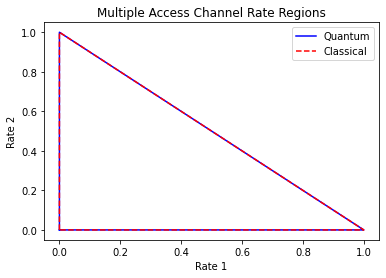


Uniform Priors Rate Region


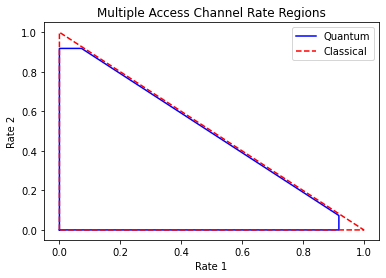

CPU times: user 21.9 s, sys: 136 ms, total: 22 s
Wall time: 22 s


In [10]:
%%time

np.random.seed(45)
local_violation, local_rate_tuple = mac_rate_region(local_ansatz, finger_printing_ineq, scan_range_10)

## Quantum Communication Ansatz

iteration :  0 , score :  4.7417586476411335
iteration :  25 , score :  6.791055263798078
iteration :  50 , score :  6.928121481162977
iteration :  75 , score :  6.967484397010848
iteration :  100 , score :  6.982753758222049
iteration :  125 , score :  6.990131867350193
max score :  6.994077421596148
classical bound :  7
opt behavior :  [[9.87830919e-01 9.90978659e-01 3.39778398e-04 9.87829788e-01
  9.90977525e-01 3.39857404e-04 2.12989551e-03 9.98209027e-04
  9.97885165e-01]
 [1.21690810e-02 9.02134105e-03 9.99660222e-01 1.21702119e-02
  9.02247468e-03 9.99660143e-01 9.97870104e-01 9.99001791e-01
  2.11483529e-03]]
rate triple :  (0.9720088766179167, 0.9720055962306846, 0.9720159168693367)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))

Max Rate Region


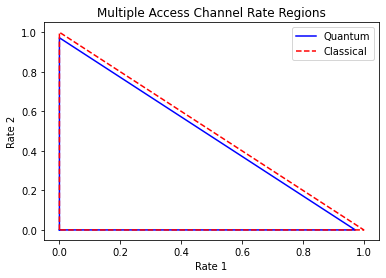


Uniform Priors Rate Region


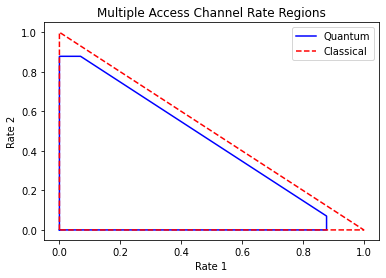

CPU times: user 33.5 s, sys: 231 ms, total: 33.7 s
Wall time: 33.8 s


In [12]:
%%time

np.random.seed(45)

arb_violation, arb_rate_tuple = mac_rate_region(arb_ansatz, finger_printing_ineq, scan_range_10)

## Real Quantum Ansatz

iteration :  0 , score :  4.173226988632404
iteration :  25 , score :  6.564755234862025
iteration :  50 , score :  6.6683761753824555
iteration :  75 , score :  6.730781542075146
iteration :  100 , score :  6.8628630627641245
iteration :  125 , score :  6.960361753634791
max score :  6.990115989422968
classical bound :  7
opt behavior :  [[9.96289050e-01 6.50158308e-04 2.42794626e-03 6.57507615e-04
  9.87486475e-01 9.82339718e-01 2.46199778e-03 9.82262598e-01
  9.77140391e-01]
 [3.71094993e-03 9.99349842e-01 9.97572054e-01 9.99342492e-01
  1.25135248e-02 1.76602815e-02 9.97538002e-01 1.77374017e-02
  2.28596092e-02]]
rate triple :  (0.9629320476637808, 0.962932094332686, 0.962946045291996)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

Max Rate Region


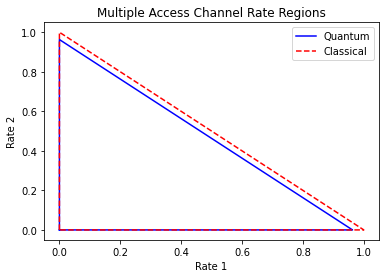


Uniform Priors Rate Region


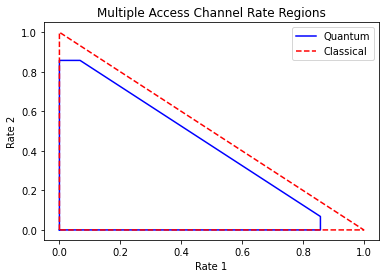

CPU times: user 14.5 s, sys: 101 ms, total: 14.6 s
Wall time: 14.5 s


In [13]:
%%time

np.random.seed(45)

real_violation, real_rate_tuple = mac_rate_region(real_ansatz, finger_printing_ineq, scan_range_10)

## Entanglement Assisted Classical Ansatz

iteration :  0 , score :  5.213209536621592
iteration :  25 , score :  7.2224277148596245
iteration :  50 , score :  7.4732849886932815
iteration :  75 , score :  7.494563267360207
iteration :  100 , score :  7.498797472284402
iteration :  125 , score :  7.4997282331278505
max score :  7.499937942029508
classical bound :  7
opt behavior :  [[9.99958254e-01 2.50568684e-01 2.49255346e-01 2.50713938e-01
  9.99962904e-01 2.50207531e-01 2.49142749e-01 2.50059756e-01
  9.99964788e-01]
 [4.17462046e-05 7.49431316e-01 7.50744654e-01 7.49286062e-01
  3.70960298e-05 7.49792469e-01 7.50857251e-01 7.49940244e-01
  3.52120339e-05]]
rate triple :  (0.5494298774549073, 0.5494298780207525, 0.5494298801837147)
priors tuple :  (tensor([0.5, 0. , 0.5], requires_grad=True), tensor([0.5, 0. , 0.5], requires_grad=True))

Max Rate Region


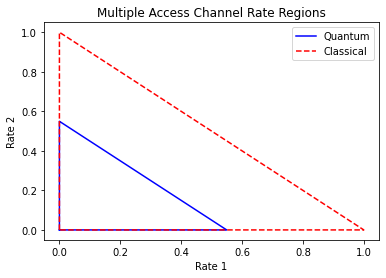


Uniform Priors Rate Region


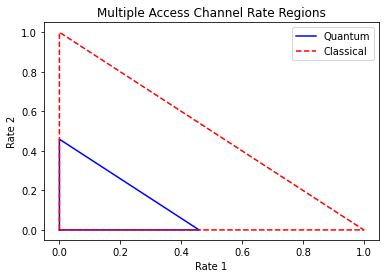

In [14]:
np.random.seed(45)

ea_violation, ea_rate_tuple = mac_rate_region(ea_ansatz, finger_printing_ineq, scan_range_10)

iteration :  0 , score :  6.125547174013417
iteration :  25 , score :  7.441423204878769
iteration :  50 , score :  7.498066208696281
iteration :  75 , score :  7.499957645400449
iteration :  100 , score :  7.499999131431995
iteration :  125 , score :  7.49999998235677
max score :  7.499999999642099
opt settings :  [[array([], shape=(1, 0), dtype=float64)], [array([[ 2.94741223],
       [ 0.85300047],
       [-1.24136377]]), array([[-3.33577307],
       [ 0.85300047],
       [-1.24136377]])]]
classical bound :  7
opt behavior :  [[1.00000000e+00 2.49992785e-01 2.49993851e-01 2.49992786e-01
  1.00000000e+00 2.50013364e-01 2.49993852e-01 2.50013363e-01
  1.00000000e+00]
 [5.01553629e-19 7.50007215e-01 7.50006149e-01 7.50007214e-01
  9.96436789e-20 7.49986636e-01 7.50006148e-01 7.49986637e-01
  1.04881817e-18]]
rate triple :  (0.548803316734487, 0.548803316734487, 0.5488033167344875)
priors tuple :  (tensor([0.5, 0.5, 0. ], requires_grad=True), tensor([0.5, 0.5, 0. ], requires_grad=True))

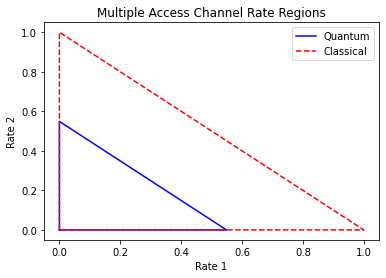


Uniform Priors Rate Region


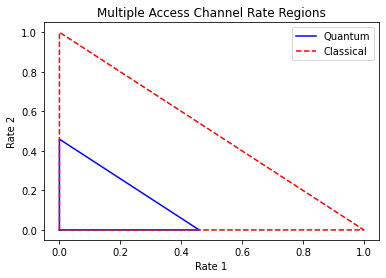

In [56]:
np.random.seed(45)

bell_ea_violation, bell_ea_rate_tuple = mac_rate_region(bell_ea_ansatz, finger_printing_ineq, scan_range_10)

## "Perfect" Entanglement-Assisted Strategy 

id :  335
rate tuple :  (0.5487949406953985, 0.5487949406953985, 0.5487949406953989)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.5, 0.5], requires_grad=True))


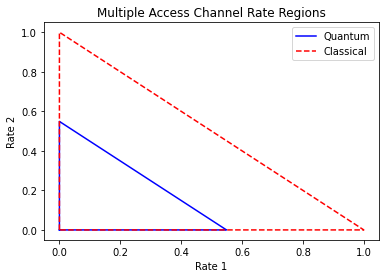

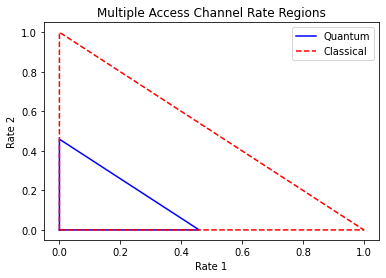

In [20]:
perf_ea_behavior = np.array([
    [1,0.25,0.25,0.25,1,0.25,0.25,0.25,1],
    [0,0.75,0.75,0.75,0,0.75,0.75,0.75,0]
])

perf_ea_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        perf_ea_rates.append(bisender_mac_mutual_info(perf_ea_behavior, priors_x, priors_y))

        
perf_ea_rate_sums = [sum(rate_set) for rate_set in perf_ea_rates]
max_perf_ea_rate_sum = max(perf_ea_rate_sums)
max_perf_ea_rate_id = perf_ea_rate_sums.index(max_perf_ea_rate_sum)
max_perf_ea_rate_tuple = perf_ea_rates[max_perf_ea_rate_id]

print("id : ", max_perf_ea_rate_id)
print("rate tuple : ", max_perf_ea_rate_tuple)
print("priors tuple : ", priors[max_perf_ea_rate_id])
plot_rate_region(max_perf_ea_rate_tuple)

uniform_rates = bisender_mac_mutual_info(perf_ea_behavior, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)

## Rate Region for the "Perfect" Finger Printing Strategy

9
id :  334
rate tuple :  (1.0000000000000002, 0.970950594454669, 1.0000000000000002)
priors tuple :  (tensor([0. , 0.5, 0.5], requires_grad=True), tensor([0. , 0.4, 0.6], requires_grad=True))


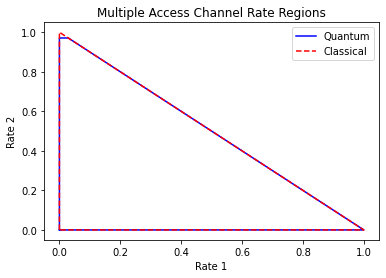

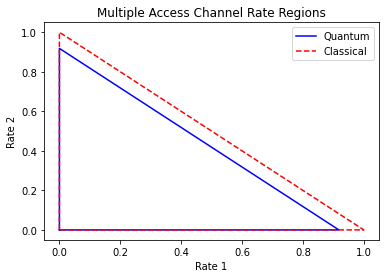

In [54]:
perfect_behavior = np.array([
    [1,0,0,0,1,0,0,0,1],[0,1,1,1,0,1,1,1,0]
])

print(np.sum(np.sum(perfect_behavior * finger_printing_ineq)))

perf_rates = []
priors = []
for priors_x in priors_scan_range(10):
    for priors_y in priors_scan_range(10):
        priors.append((priors_x, priors_y))
        perf_rates.append(bisender_mac_mutual_info(perfect_behavior, priors_x, priors_y))

        
perf_rate_sums = [sum(rate_set) for rate_set in perf_rates]
max_perf_rate_sum = max(perf_rate_sums)
max_perf_rate_id = perf_rate_sums.index(max_perf_rate_sum)
max_perf_rate_tuple = perf_rates[max_perf_rate_id]

print("id : ", max_perf_rate_id)
print("rate tuple : ", max_perf_rate_tuple)
print("priors tuple : ", priors[max_perf_rate_id])
plot_rate_region(max_perf_rate_tuple)

uniform_rates = bisender_mac_mutual_info(perfect_behavior, np.ones(3)/3, np.ones(3)/3)

plot_rate_region(uniform_rates)

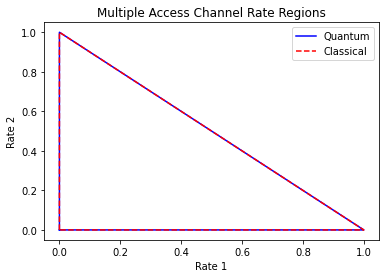

In [17]:
a = plot_rate_region((1,1,1))

In [32]:
local_r1_vals, local_r2_vals = rate_region_vertices((1,1,1))
qmac_r1_vals, qmac_r2_vals = rate_region_vertices(arb_rate_tuple)
ea_r1_vals, ea_r2_vals = rate_region_vertices(ea_rate_tuple)
perf_ea_r1_vals, perf_ea_r2_vals = rate_region_vertices(max_perf_ea_rate_tuple)
perf_r1_vals, perf_r2_vals = rate_region_vertices(max_perf_rate_tuple)

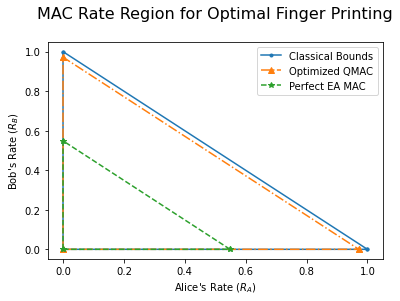

In [53]:
plt.plot(local_r1_vals, local_r2_vals, ".-", label="Classical Bounds")
plt.plot(qmac_r1_vals, qmac_r2_vals, "^-.", label="Optimized QMAC")
plt.plot(perf_ea_r1_vals, perf_ea_r2_vals, "*--", label="Perfect EA MAC")
plt.title("MAC Rate Region for Optimal Finger Printing\n", size=16)

plt.ylabel(r"Bob's Rate ($R_B$)")
plt.xlabel(r"Alice's Rate ($R_A$)")
plt.legend()

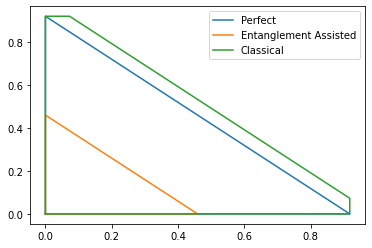

In [19]:
perfect_behavior = np.array([
    [1,0,0,0,1,0,0,0,1],[0,1,1,1,0,1,1,1,0]
])

ea_behavior = np.array([
    [1,0.25,0.25,0.25,1,0.25,0.25,0.25,1],
    [0,0.75,0.75,0.75,0,0.75,0.75,0.75,0]
])
cl_behavior = np.array([
    [1,0,1,0,1,0,1,0,1],
    [0,1,0,1,0,1,0,1,0]
])

perf_uniform_rates = bisender_mac_mutual_info(perfect_behavior, np.ones(3)/3, np.ones(3)/3)
ea_uniform_rates = bisender_mac_mutual_info(ea_behavior, np.ones(3)/3, np.ones(3)/3)
cl_uniform_rates = bisender_mac_mutual_info(cl_behavior, np.ones(3)/3, np.ones(3)/3)


perf_r1_vals, perf_r2_vals = rate_region_vertices(perf_uniform_rates)
plt.plot(perf_r1_vals, perf_r2_vals, label="Perfect")

ea_r1_vals, ea_r2_vals = rate_region_vertices(ea_uniform_rates)
plt.plot(ea_r1_vals, ea_r2_vals, label="Entanglement Assisted")

cl_r1_vals, cl_r2_vals = rate_region_vertices(cl_uniform_rates)
plt.plot(cl_r1_vals, cl_r2_vals, label="Classical")

plt.legend()

